### Определение перспективного тарифа для телеком компании


Проект посвящен анализу двух тарифных планов "Смарт" и "Ультра" в компании «Мегалайн» — федерального оператора сотовой связи. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
В проекте будет проведен предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users.info()
calls.info()
internet.info()
messages.info()
print(tariffs)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null o

В качестве данных нам предоставлено 5 файлов, 4 из которых в качестве связующего элемента имеют данные о user_id, пятый файл tarrifs представляет собой таблицу-словарь из 2 строк по вводным каждого тарифа.
В таблице users даются данные о 500 уникальных пользователях, каких-то аномальных, на первый взгляд, данных не обнаружено, дубликатов также нет. Есть пропуски в колонке churn_date у тех пользователей, которые по описанию задания продолжают пользоваться тарифом. В колонке "тариф" проставлены только те тарифы, которые нас интересуют по заданию.
В таблицах calls, internet, messages приведены данные по каждому типу действий в тарифах (звонки, использование интернета, сообщения), пропущенных значений, дубликатов нет, каких-то аномальных данных, на первый взгляд, не обнаружено.

### Шаг 2. Подготовьте данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

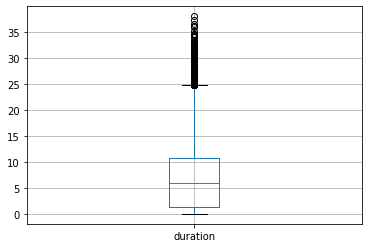

In [2]:
import matplotlib.pyplot as plt
calls.info()
calls.boxplot(column = 'duration')
calls['duration'].describe()


In [3]:
calls['duration'] = calls['duration'].round()
calls['duration'] = calls['duration'].round()
calls['duration'] = calls['duration'].astype('int')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d') 
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls_pivot = calls.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc = 'sum').reset_index()
print(calls_pivot.head(5))

   user_id  month  duration
0     1000      5       149
1     1000      6       159
2     1000      7       319
3     1000      8       391
4     1000      9       439


По таблице calls можно прокомментировать следующее:
1. Дубликатов в колонке с идентификатором звонка не обнаружено;   
2. колонка duration была переведена в целочисленный формат, так как в тарифах всегда идет округление секунд до целых минут и для упрощения дальнейших расчетов;
3. колонка call_date была переведена в формат даты и с ее использованием далее был добавлен столбец с месяцем звонка;
4. Всего звонков 202 607 в выборке, но есть звонки с продолжительностью 0, что предположительно означает пропущенный звонок, так как в дальнейшем мы будем использовать этот столбец для вычислений выручки, нулевые значения не должны отразиться на общей картине по выборке. Оставим эти данные как есть.

Далее была собрана сводная таблица по номеру пользователя, месяцам и продолжительности звонков.

* было проведено округление значений звонков до целого в соответствии с условием задачи и комментарием ревьюера.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

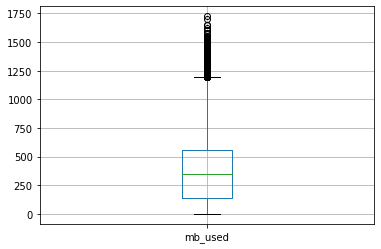

In [4]:
internet.info()
internet.boxplot(column = 'mb_used')
internet['mb_used'].describe()

In [5]:
internet['mb_used'] = internet['mb_used'].astype('int')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%dT%H:%M:%S') 
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet_pivot = internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = 'sum').reset_index()
print(internet_pivot.head(5))

   user_id  month  mb_used
0     1000      5     2252
1     1000      6    23213
2     1000      7    13988
3     1000      8    14043
4     1000      9    14556


По таблице internet можно прокомментировать следующее:
1. Дубликатов в колонке с уникальным идентификатором не обнаружено;   
2. колонка mb_used была переведена в целочисленный формат;
3. колонка session_date была переведена в формат даты и с ее использованием далее был добавлен столбец с месяцем;
4. Есть ряд сессий, трафик по которым составил 0МБ, так как в дальнейшем мы будем использовать этот столбец для вычислений выручки, нулевые значения не должны отразиться на общей картине по выборке, также эти данные помогут понять реальную картину по использованию тарифа. Если мы их выкинем, то получим искаженную выборку, где все пользователи пользуются всеми возможностями тарифа. Оставим эти данные как есть.

Далее была собрана сводная таблица по номеру пользователя, месяцам и объему трафика.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


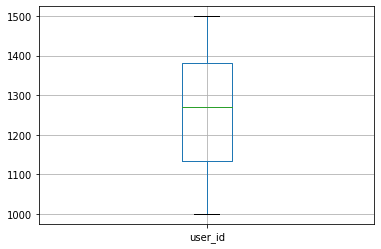

In [6]:
messages.info()
messages.boxplot()

In [7]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d') 
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
new_columns = ['user_id','month','q_messages']

messages_pivot =messages.pivot_table(index = ['user_id','month'], values = 'id', aggfunc = 'count').reset_index()
messages_pivot.set_axis(new_columns, axis='columns',inplace = True)
print(messages_pivot.head(5))

   user_id  month  q_messages
0     1000      5          22
1     1000      6          60
2     1000      7          75
3     1000      8          81
4     1000      9          57


По таблице messages можно прокомментировать следующее:
1. Дубликатов в колонке с уникальным идентификатором не обнаружено;   
2. колонка message_date была переведена в формат даты и с ее использованием далее был добавлен столбец с месяцем.
Далее была собрана сводная таблица по номеру пользователя, месяцу и количеству сообщений.

In [8]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d') 
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_month']= pd.DatetimeIndex(users['reg_date']).month
users['churn_month'] = pd.DatetimeIndex(users['churn_date']).month
users['last_month']=users['churn_month']
users['last_month'] = users['last_month'].fillna(12)
users['active_months'] = users['last_month']-users['reg_month']+1
users_short = users.loc[:,['user_id','tariff','active_months','city']]
print(users_short.head(5))

   user_id tariff  active_months         city
0     1000  ultra            8.0    Краснодар
1     1001  smart            2.0       Москва
2     1002  smart            7.0  Стерлитамак
3     1003  ultra            5.0       Москва
4     1004  ultra            8.0  Новокузнецк


В таблице users были переведены в формат даты колонки churn_date и reg_date, созданы столбцы с месяцами регистрации и расторжения.
Дополнительно был посчитан столбец с количеством активных месяцев пользования.

In [9]:
final_data = calls_pivot.merge(internet_pivot,on = ['user_id','month'],how = 'outer')
final_data = final_data.merge(messages_pivot, on = ['user_id', 'month'], how = 'outer')
final_data = final_data.merge(users_short, on = ['user_id'])
final_data['duration'] = final_data['duration'].fillna(0)
final_data['mb_used'] = final_data['mb_used'].fillna(0)
final_data['q_messages'] = final_data['q_messages'].fillna(0)
final_data['duration'] = final_data['duration'].astype('int')
final_data['mb_used'] = final_data['mb_used'].astype('int')
final_data['q_messages'] = final_data['q_messages'].astype('int')
print(final_data.info())
print(final_data.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id          3214 non-null int64
month            3214 non-null int64
duration         3214 non-null int64
mb_used          3214 non-null int64
q_messages       3214 non-null int64
tariff           3214 non-null object
active_months    3214 non-null float64
city             3214 non-null object
dtypes: float64(1), int64(5), object(2)
memory usage: 226.0+ KB
None
   user_id  month  duration  mb_used  q_messages tariff  active_months  \
0     1000      5       149     2252          22  ultra            8.0   
1     1000      6       159    23213          60  ultra            8.0   
2     1000      7       319    13988          75  ultra            8.0   
3     1000      8       391    14043          81  ultra            8.0   
4     1000      9       439    14556          57  ultra            8.0   

        city  
0  Краснодар  
1  Краснодар  
2  Краснодар  
3  Краснодар  
4  Кр

Было создана отдельная таблица, в которой были объединены данные по номеру пользователя, тарифу и количеству активных месяцев из таблицы users_short, данные по каждому пользователю помесячно по продолжительности звонков, количеству сообщений и использования интернета из таблиц calls_pivot, messages_pivot и internet_pivot).
Далее в столбцах duration, q_messages и mb_used в пропущенных значениях были проставлены 0, затем столбцы были переведены в формат int.



In [10]:
def base_revenue(tariff):
    if tariff['tariff'] == 'smart':
        return 550
    else:
        return 1950
final_data['base_revenue'] = final_data.apply(base_revenue, axis = 1)

def additional_revenue_calls(x):
    if x['tariff'] == 'smart':
        if x['duration'] <= 500:
            return 0
        else:
            additional_revenue_smart = (x['duration'] - 500) * 3
            return additional_revenue_smart
    else:
        if x['duration'] <= 3000:
            return 0
        else:
            additional_revenue_ultra = (x['duration'] - 3000) 
            return additional_revenue_ultra


final_data['additional_revenue_calls'] = final_data.apply(additional_revenue_calls, axis = 1)

def additional_revenue_internet(x):
    if x['tariff'] == 'smart':
        if x['mb_used'] <= 15360:
            return 0
        else:
            additional_revenue_smart_int = (x['mb_used'] - 15360) * 200 / 1024
            return additional_revenue_smart_int
    else:
        if x['mb_used'] <= 30720:
            return 0
        else:
            additional_revenue_ultra_int = (x['mb_used'] - 30720) * 150/1024
            return additional_revenue_ultra_int


final_data['additional_revenue_internet'] = final_data.apply(additional_revenue_internet, axis = 1)

def additional_revenue_sms(x):
    if x['tariff'] == 'smart':
        if x['q_messages'] <= 50:
            return 0
        else:
            additional_revenue_smart_sms = (x['q_messages'] - 50) * 3
            return additional_revenue_smart_sms
    else:
        if x['q_messages'] <= 1000:
            return 0
        else:
            additional_revenue_ultra_sms = (x['q_messages'] - 1000) 
            return additional_revenue_ultra_sms


final_data['additional_revenue_sms'] = final_data.apply(additional_revenue_sms, axis = 1)

final_data['total_revenue'] = final_data['base_revenue'] + final_data['additional_revenue_calls'] + final_data['additional_revenue_internet'] + final_data['additional_revenue_sms']
final_data['total_revenue'] = final_data['total_revenue'].astype('int')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
user_id                        3214 non-null int64
month                          3214 non-null int64
duration                       3214 non-null int64
mb_used                        3214 non-null int64
q_messages                     3214 non-null int64
tariff                         3214 non-null object
active_months                  3214 non-null float64
city                           3214 non-null object
base_revenue                   3214 non-null int64
additional_revenue_calls       3214 non-null int64
additional_revenue_internet    3214 non-null float64
additional_revenue_sms         3214 non-null int64
total_revenue                  3214 non-null int64
dtypes: float64(2), int64(9), object(2)
memory usage: 351.5+ KB


В датасете были посчитаны следующие столбцы:
1. выручка от ежемесячной абонентской платы;
2. дополнительная выручка от звонков сверх лимита по тарифу;
3. дополнительная выручка от интернета сверх тарифа;
4. дополнительная выручка от текстовых сообщений;
5. столбец с итоговой выручкой за месяц как сумма столбцов из п1.-4. Далее этот столбец был переведен в формат int для дальнейшего удобства.

### Шаг 3. Проанализируйте данные.

In [11]:
print(final_data.pivot_table(index = 'tariff', values = ['duration', 'mb_used', 'q_messages'], aggfunc = 'mean'))

         duration       mb_used  q_messages
tariff                                     
smart   394.26873  16187.578735   33.384029
ultra   496.88934  19450.643655   49.363452


Из этой сводной таблицы мы видим следующее:
1. в среднем на тарифе "Ультра" разговаривают на 25% больше, чем на тарифе "Смарт";
2. пользуются интернетом на 20% больше на тарифе "Ультра";
3. Отправляют на 50% больше сообщений на тарифе "Ультра".
При этом, пользователи тарифа "Ультра" по звонкам и количеству сообщений не выходят за лимиты более дешевого тарифа "Смарт", а интернет превышает лимит тарифа "Смарт" на 4ГБ в месяц.

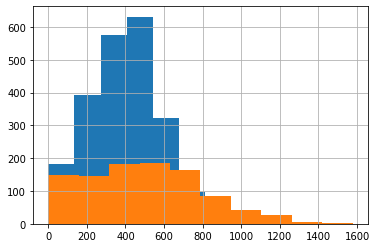

In [12]:
import numpy as np
import matplotlib.pyplot as plt
final_data_smart = final_data.query('tariff == "smart"')
final_data_ultra = final_data.query('tariff == "ultra"')
final_data_smart['duration'].hist()
final_data_ultra['duration'].hist()



In [13]:
print(final_data_smart['duration'].describe())
print("Дисперсия по продолжительности телефонных разговоров на тарифе Смарт:",np.var(final_data_smart['duration'],ddof=1))
print("Стандартное отклонение по продолжительности телефонных разговоров на тарифе Смарт:",np.std(final_data_smart['duration'],ddof=1))

count    2229.000000
mean      394.268730
std       179.891988
min         0.000000
25%       267.000000
50%       398.000000
75%       515.000000
max      1355.000000
Name: duration, dtype: float64
Дисперсия по продолжительности телефонных разговоров на тарифе Смарт: 32361.127482274216
Стандартное отклонение по продолжительности телефонных разговоров на тарифе Смарт: 179.89198837712095


In [14]:
print(final_data_ultra['duration'].describe())
print("Дисперсия по продолжительности телефонных разговоров на тарифе Ультра:",np.var(final_data_ultra['duration'],ddof=1))
print("Стандартное отклонение по продолжительности телефонных разговоров на тарифе Ультра:",np.std(final_data_ultra['duration'],ddof=1))

count     985.000000
mean      496.889340
std       299.704816
min         0.000000
25%       269.000000
50%       489.000000
75%       709.000000
max      1577.000000
Name: duration, dtype: float64
Дисперсия по продолжительности телефонных разговоров на тарифе Ультра: 89822.97656308036
Стандартное отклонение по продолжительности телефонных разговоров на тарифе Ультра: 299.7048157155309


Мы можем выявить следующие различия по тарифам:
1. На тарифе Смарт большая часть абонентов (~70%) ежемесячно укладывается в лимит связи 500 минут, по остальным 30% идет превышение лимита и как следствие дополнительная выручка по звонкам. Средняя продолжительность звонков в месяц составляет 394м, при медиане 398, в целом данные распределены нормально.
2. На тарифе "Ультра" больше половины абонентов укладываются в лимит тарифа "Смарт", что впоследствии может сказаться на том, что часть людей перейдет на более дешевый тариф "Смарт". В целом на этом тарифе разговаривают по телефону больше, что также можно увидеть по показателям по срезу тарифа "Ультра". Также, интересно, что максимальное значение разговоров в месяц в два раза меньше установленного лимита бесплатных звонков.

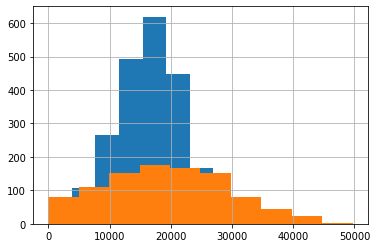

In [15]:
final_data_smart['mb_used'].hist()
final_data_ultra['mb_used'].hist()

In [16]:
print(final_data_smart['mb_used'].describe())
print("Дисперсия по использованию интернета на тарифе Смарт:",np.var(final_data_smart['mb_used'],ddof=1))
print("Стандартное отклонение по использованию интернета на тарифе Смарт:",np.std(final_data_smart['mb_used'],ddof=1))

count     2229.000000
mean     16187.578735
std       5863.430302
min          0.000000
25%      12625.000000
50%      16482.000000
75%      20017.000000
max      38510.000000
Name: mb_used, dtype: float64
Дисперсия по использованию интернета на тарифе Смарт: 34379814.908183135
Стандартное отклонение по использованию интернета на тарифе Смарт: 5863.430302151049


In [17]:
print(final_data_ultra['mb_used'].describe())
print("Дисперсия по использованию интернета на тарифе Ультра:",np.var(final_data_ultra['mb_used'],ddof=1))
print("Стандартное отклонение по использованию интернета на тарифе Ультра:",np.std(final_data_ultra['mb_used'],ddof=1))

count      985.000000
mean     19450.643655
std      10077.999744
min          0.000000
25%      11762.000000
50%      19289.000000
75%      26810.000000
max      49701.000000
Name: mb_used, dtype: float64
Дисперсия по использованию интернета на тарифе Ультра: 101566078.84341753
Стандартное отклонение по использованию интернета на тарифе Ультра: 10077.999744166375


Судя по графикам и описательным статистикам, использование интернета является ключевой услугой, приносящей дополнительную выручку.
1. на тарифе Смарт ~55-60% пользователей превышают лимит и доплачивают за дополнительный трафик.
2. на тарифе Ультра ~ 80% используют бесплатный трафик в пакете в полном объеме, что может говорить о том, что потребители выбирают этот тариф за включенный в него интернет,т.к. по минутам и сообщениям большая часть абонентов не использует свой лимит.

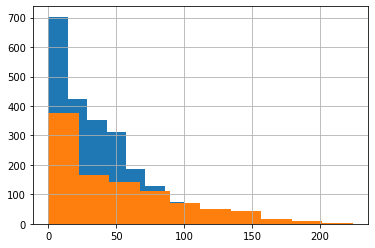

In [18]:
final_data_smart['q_messages'].hist()
final_data_ultra['q_messages'].hist()

In [19]:
print(final_data_smart['q_messages'].describe())
print("Дисперсия по количеству сообщений на тарифе Смарт:",np.var(final_data_smart['q_messages'],ddof=1))
print("Стандартное отклонение по количеству сообщений на тарифе Смарт:",np.std(final_data_smart['q_messages'],ddof=1))

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: q_messages, dtype: float64
Дисперсия по количеству сообщений на тарифе Смарт: 796.8129584480083
Стандартное отклонение по количеству сообщений на тарифе Смарт: 28.22787555676141


In [20]:
print(final_data_ultra['q_messages'].describe())
print("Дисперсия по количеству сообщений на тарифе Ультра:",np.var(final_data_ultra['q_messages'],ddof=1))
print("Стандартное отклонение по количеству сообщений на тарифе Ультра:",np.std(final_data_ultra['q_messages'],ddof=1))

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: q_messages, dtype: float64
Дисперсия по количеству сообщений на тарифе Ультра: 2285.2661425446736
Стандартное отклонение по количеству сообщений на тарифе Ультра: 47.804457350174715


На обоих тарифах мы видим сильно смещенное влево распределение. Больше половины пользователей обоих тарифов отправляют в месяц не более 50 сообщений.
На тарифе "Смарт" похожая картина как и со звонками: ~25% пользователей выходят за ежемесячный лимит, при этом на тарифе "Ультра" большая часть выборки укладывается в 100 сообщений в месяц, что составляет 10% от лимита.
Можно сказать о том, что услуга смс-сообщений не является ключевой для пользователей и часто используемой. 

### Шаг 4. Проверьте гипотезы.

In [21]:
from scipy import stats as st
import numpy as np

alpha = .01

results = st.ttest_ind(final_data_smart['total_revenue'], final_data_ultra['total_revenue'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print(final_data.pivot_table(index = 'tariff', values = 'total_revenue', aggfunc = 'mean'))

p-значение:  1.226189997907554e-215
Отвергаем нулевую гипотезу
        total_revenue
tariff               
smart     1194.241812
ultra     2059.143147


По заданию нам необходимо проверить гипотезу, что средние выручки по тарифам Ультра и Смарт различаются.
Сформулируем следующие гипотезы:

H0: Average Rev(ultra) == Average Rev(smart)

H1: Average Rev(ultra) != Average Rev(smart)

Так как мы берем 2 разные выборки: пользователи тарифа Смарт и пользователи тарифа Ультра, которые не являются зависимыми друг от друга, был для расчета был принят метод st.ttest_ind.

Мы проверили гипотезу о равенстве средних ежемесячных выручек по тарифам Ультра и Смарт. С вероятностью 99% эта гипотеза неверна и мы можем признать, что размер средней выручки по тарифам Ультра и Смарт неравен.
Дополнительно я собрала сводную таблицу, по которой мы видим, что средняя выручка выше на 75% по тарифу Ультра. Раннее мы проанализировали использование пакетов для тарифов и вывели, что на тарифе Смарт, в основном, доплачивают за дополнительный интернет, но это не компенсирует разницу в базовом ежемесячном платеже.

In [23]:
def city_type(x):
    if x['city'] == "Москва":
        return 'Москва'
    else:
        return 'другой'
final_data['city_type'] = final_data.apply(city_type, axis = 1)

final_data_moscow = final_data.query('city_type == "Москва"')
final_data_other = final_data.query('city_type == "другой"')

alpha = .05

results = st.ttest_ind(final_data_moscow['total_revenue'], final_data_other['total_revenue'])

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print(final_data.pivot_table(index = 'city_type', values = 'total_revenue', aggfunc = 'mean'))


p-значение:  0.4081228281984126
Не получилось отвергнуть нулевую гипотезу
           total_revenue
city_type               
Москва       1482.710311
другой       1453.816750


По заданию нам необходимо проверить гипотезу, что средняя выручка у абонентов в Москве отличается от абонентов в других регионах.
Сформулируем следующие гипотезы:

H0: Average Rev(Moscow) == Average Rev(Other)

H1: Average Rev(Moscow) != Average Rev(Other)

Мы берем 2 разных выборки по жителям Москвы и жителям других регионов, данные между собой не связаны, поэтому для расчета был принят метод st.ttest_ind.

Гипотеза о равенстве средней выручке между Москвой и регионами с 95% подтверждена и мы можем сделать вывод что средний размер выручки не зависит от разделения абонентов по принципу "Москва/другой регион", также мы можем это наглядно увидеть по сводной таблице, где разница в средней выручке составила 30 рублей, т.е. отклонение в пределах 2%.

### Шаг 5. Общие выводы.

На основании исследования проведенного выше мы можем ответить Коммерческом департаменту следующее:

1. С вероятностью 99% мы можем сказать, что средняя выручка по тарифу Ультра отличается от средней выручки по тарифу Смарт. 
Также мы выявили, что несмотря на то, что дополнительные услуги на тарифе Смарт  стоят дороже, это не компенсирует разницу в ежемесячных платежах на разных  тарифах: средняя ежемесячная выручка на тарифе Ультра на 75% выше, чем на тарифе Смарт.
Для проведения рекламной компании Коммерческий отдел в качестве преимущества тарифа Ультра может использовать информацию о включенном пакете интернета на основании следующих фактов:
а) на тарифе Смарт ~55-60% абонентов выходят за лимиты стандартного пакета и докупают дополнительный трафик;
б) Тариф Ультра, как можно предположить, пользователи выбирают за объем включенного пакета интернета, ~80% абонентов укладываются в лимит, ~20% доплачивают за дополнительный трафик, при этом если мы посмотрим использование включенного лимита смс и звонков в тариф Ультра, то никто из пользователей не выбирает полный пакет звонков и смс на этом тарифе и ~50% абонентов было бы достаточно пакета в тарифе с низким ежемесячным платежом Смарт.

2. С вероятностью 95% мы можем сказать, что размер средней выручки не зависит от того, является ли абонент жителем Москвы или нет.

Можно сказать, что в выборку попали регионы с похожим типом потребления услуг. Возможно, если бы в выборку попали регионы с другой доступностью интернета (Норильск, Чукотка и т.д.) распределение тарифов и выручки было бы другим.


Таким образом, можно посоветовать Коммерческому департаменту мы можем сказать, что тариф Ультра приносит больше выручки, факторов влияния по регионам Москва/другие регионы не обнаружено. Далее можно было бы увеличить выборку и проверить является ли интернет основной используемой услугой и как меняется его потребление при выборке по большему количеству абонентов. 